In [1]:
import pickle

# Load ARIMA model
with open('arima_model.pkl', 'rb') as f:
    arima_model = pickle.load(f)

In [8]:
# Load LSTM model with window size 20
model_lstm_20 = load_model('model_lstm_20.h5')

# Load LSTM model with window size 30
model_lstm_30 = load_model('model_lstm_30.h5')

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Define custom objects
custom_objects = {'mse': MeanSquaredError()}

# Load Sequence-to-Vector RNN model
model_seq2vec = load_model('model_seq2vec.h5', custom_objects=custom_objects)

# Load Sequence-to-Sequence RNN model
model_seq2seq = load_model('model_seq2seq.h5', custom_objects=custom_objects)

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the same data
data = yf.download('SPY', start='2015-12-01', end='2018-01-31')
data = data[['Close']]

# Split into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Normalize the data (if required for RNN/LSTM models)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare test data for each model
# ARIMA: No preprocessing needed
# RNN/LSTM: Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20  # Use the same sequence length as during training
X_test_rnn, y_test_rnn = create_sequences(scaled_data[train_size:], seq_length)
X_test_rnn = X_test_rnn.reshape((X_test_rnn.shape[0], X_test_rnn.shape[1], 1))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [12]:
# ARIMA predictions
arima_predictions = arima_model.predict(start=len(train_data), end=len(data)-1, typ='levels')

# RNN predictions
rnn_seq2vec_predictions = model_seq2vec.predict(X_test_rnn)
rnn_seq2vec_predictions = scaler.inverse_transform(rnn_seq2vec_predictions)

rnn_seq2seq_predictions = model_seq2seq.predict(X_test_rnn)
rnn_seq2seq_predictions = rnn_seq2seq_predictions[:, -1, :]  # Take the last time step's output
rnn_seq2seq_predictions = scaler.inverse_transform(rnn_seq2seq_predictions)

# LSTM predictions
lstm_20_predictions = model_lstm_20.predict(X_test_rnn)
lstm_20_predictions = scaler.inverse_transform(lstm_20_predictions)

lstm_30_predictions = model_lstm_30.predict(X_test_rnn)
lstm_30_predictions = scaler.inverse_transform(lstm_30_predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


In [15]:
import numpy as np

# Convert ARIMA predictions to a NumPy array and flatten
arima_predictions = arima_predictions.values.flatten()  # Convert to NumPy array and flatten

# Ensure all other predictions are 1D arrays
rnn_seq2vec_predictions = rnn_seq2vec_predictions.flatten()  # Reshape to 1D
rnn_seq2seq_predictions = rnn_seq2seq_predictions.flatten()  # Reshape to 1D
lstm_20_predictions = lstm_20_predictions.flatten()  # Reshape to 1D
lstm_30_predictions = lstm_30_predictions.flatten()  # Reshape to 1D

# Ensure all predictions are of the same length
min_length = min(len(arima_predictions), len(rnn_seq2vec_predictions), len(rnn_seq2seq_predictions), len(lstm_20_predictions), len(lstm_30_predictions))

# Truncate predictions to the minimum length
arima_predictions = arima_predictions[:min_length]
rnn_seq2vec_predictions = rnn_seq2vec_predictions[:min_length]
rnn_seq2seq_predictions = rnn_seq2seq_predictions[:min_length]
lstm_20_predictions = lstm_20_predictions[:min_length]
lstm_30_predictions = lstm_30_predictions[:min_length]

# Create ensemble predictions
ensemble_predictions = np.mean([arima_predictions, rnn_seq2vec_predictions, rnn_seq2seq_predictions, lstm_20_predictions, lstm_30_predictions], axis=0)

MAE for Ensemble Model: 4.09195356211759


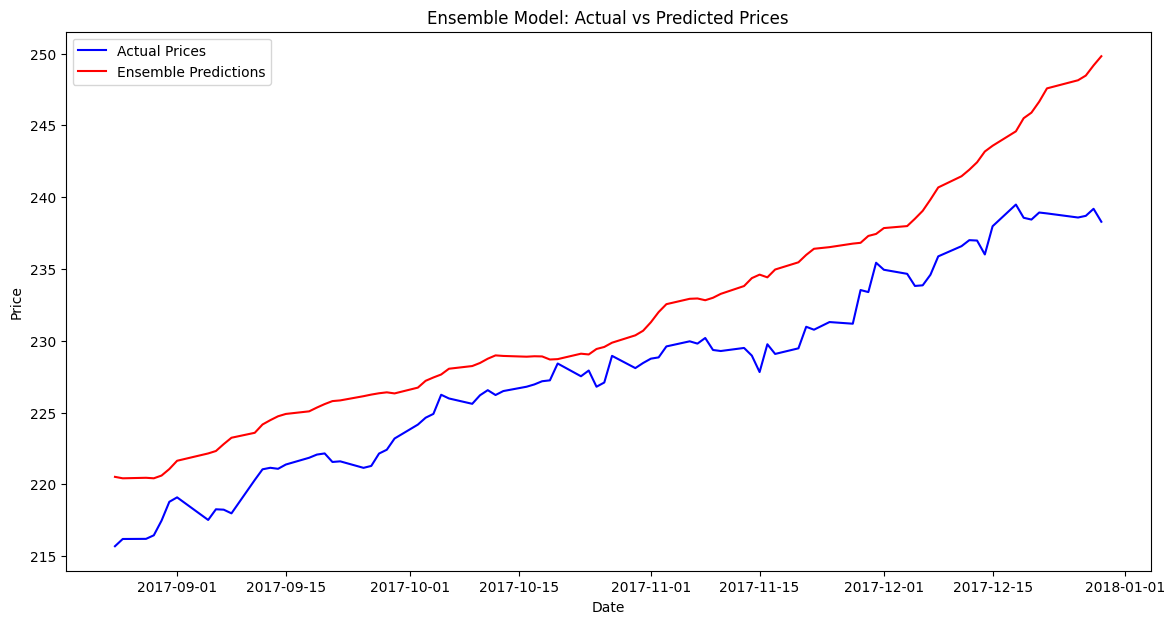

In [16]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Actual test values
y_test_actual = test_data['Close'].values[:min_length]

# Calculate MAE
mae_ensemble = mean_absolute_error(y_test_actual, ensemble_predictions)
print(f'MAE for Ensemble Model: {mae_ensemble}')

# Plot real vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index[:min_length], y_test_actual, label='Actual Prices', color='blue')
plt.plot(test_data.index[:min_length], ensemble_predictions, label='Ensemble Predictions', color='red')
plt.title('Ensemble Model: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()